# Prediction of sea ice extent over the Arctic

In this notebook we:

- retrieve gridded time series of: the NAO index, the AO index, the NINO index, CO2 concentration, and sea ice concentration;
- select an area including the Barents and Kara seas for our analysis;
- sum up all sea ice concentration in that area (~ total area over which there is sea ice);
- fit a Gaussian process over this as function of time;
- analyse results.

## 1. Retrieve and visualise data 

In [111]:
%matplotlib notebook

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import tensorflow as tf
import gpflow 
from gpflow.kernels import RBF, Periodic, RationalQuadratic, White

import warnings
warnings.simplefilter('ignore')

### Download datasets

No need, this has already been done for you! They are in `sea_ice_data/`.

In [112]:
def reshape_col_month(df, col_name):
    """ Processing data from dataframe - change from one column for year to two separate columns for year and month """
    new = pd.DataFrame(columns=['Year', 'Month', col_name])
    yr_arr, mon_arr = [], []
    for yr in df['Year'].values:
        yr_arr  = np.append( yr_arr, np.repeat(yr,12) )
        mon_arr = np.append( mon_arr, np.arange(1,13) )
    new['Year']   = yr_arr.astype(int)
    new['Month']  = mon_arr.astype(int)
    # new[col_name] = np.array(df.drop(columns='Year')).flatten()
    new[col_name] = np.array(df.drop(['Year'], axis=1)).flatten()
    return new

In [113]:
def draw_area(dat):
    """ Draw the selected area on a map of the Arctic, and plot the sea ice concentration over it. """
    plt.figure()
    ax = plt.subplot(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180,180,60,90], ccrs.PlateCarree())
    dat.isel(time=0).plot.contourf('longitude', 'latitude',ax=ax,
    levels=range(0, 100,5),cmap='Blues_r',transform=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND)
    ax.coastlines()
    ax.set_title('Sea ice concentration for a small area',size='xx-large')
    plt.show()

In [114]:
def plot_all(dates, X, Y):
    """ Plot all time series data: NAO index, AO index, NINO phase, CO2 concentration, total sea ice over area selected. """
    plt.figure()
    y_mean = Y - np.mean(Y)
    y = y_mean/max(y_mean)
    plt.plot(dates,y,label='Total sea ice')
    plt.legend()
    plt.show()

In [115]:
def plot(x, y, labels):
    """ Convenience function for plotting climate variables. """
    plt.figure()
    plt.plot(x,y)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[1])
    plt.show()

Load weather data: 

In [116]:
url = 'sea_ice_data/norm.nao.monthly.b5001.current.ascii.table'
nao = pd.read_csv(url, delim_whitespace=True, header=None)
nao.rename(columns = {0: 'Year'}, inplace=True)
nao = reshape_col_month(nao, 'NAO')
nao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nao.iterrows() ]
nao['time'] = pd.DatetimeIndex(dt)
nao = nao.drop(columns=['Day'])

url = 'sea_ice_data/nino34.long.anom.data'
nino = pd.read_csv(url, skiprows=1, skipfooter=7, delim_whitespace=True, header=None)
nino.rename(columns = {0: 'Year'}, inplace=True)
nino = reshape_col_month(nino, 'NINO')
nino['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in nino.iterrows() ]
nino['time'] = pd.DatetimeIndex(dt)
nino = nino.drop(columns=['Day'])

url = 'sea_ice_data/ao.data'
ao = pd.read_csv(url, skiprows=1, skipfooter=3, delim_whitespace=True, header=None)
ao.rename(columns = {0: 'Year'}, inplace=True)
ao = reshape_col_month(ao, 'AO')
ao['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in ao.iterrows() ]
ao['time'] = pd.DatetimeIndex(dt)

url = 'sea_ice_data/co2_mm_mlo.txt'
co2 = pd.read_csv(url, skiprows=72, delim_whitespace=True, usecols=[0,1,3], names=['Year','Month','CO2'])
co2['Day'] = 15
dt = [ datetime.date( int(row['Year']), int(row['Month']), int(row['Day']) ) for index, row in co2.iterrows() ]
co2['time'] = pd.DatetimeIndex(dt)

# Merge time series
df = pd.merge(nino,nao)
df = pd.merge(df,ao)
df = pd.merge(df,co2)
df = df.drop(columns=['Day'], axis=0)

# Load sea ice data
ds = xr.open_dataset('sea_ice_data/G10010_SIBT1850_v1.1.nc')
da = ds.seaice_conc
da = da.sel(time=slice('1979-01-01', None)) # take slice over the satellite
# era only (1979-present)

# Select area to work on
da1 = da.isel(latitude=slice(10,95),longitude=slice(65,400))

The sea ice concentration is stored in as an `xarray` dataframe structure:

In [107]:
da1

<xarray.DataArray 'seaice_conc' (time: 420, latitude: 85, longitude: 335)>
[11959500 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 87.375 87.125 86.875 ... 66.875 66.625 66.375
  * longitude  (longitude) float32 16.375 16.625 16.875 ... 99.375 99.625 99.875
  * time       (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2013-12-15
Attributes:
    short_name:     concentration
    long_name:      Sea_Ice_Concentration
    standard_name:  Sea_Ice_Concentration
    units:          Percent

- Draw sea ice at a given point in time over map;
- Selected a small area, draw sea ice only in this area (for summing later);

<IPython.core.display.Javascript object>


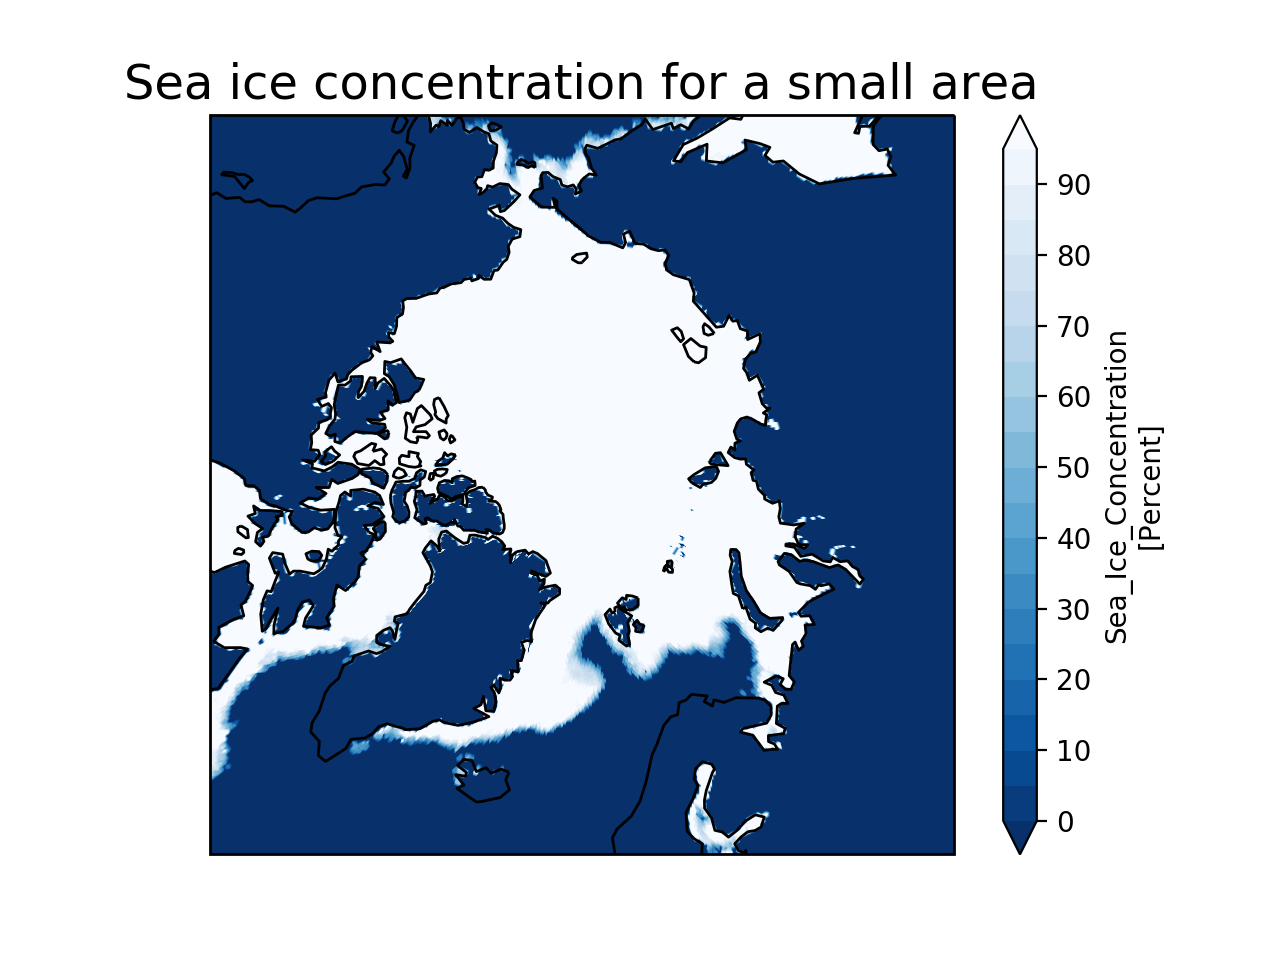

<IPython.core.display.Javascript object>


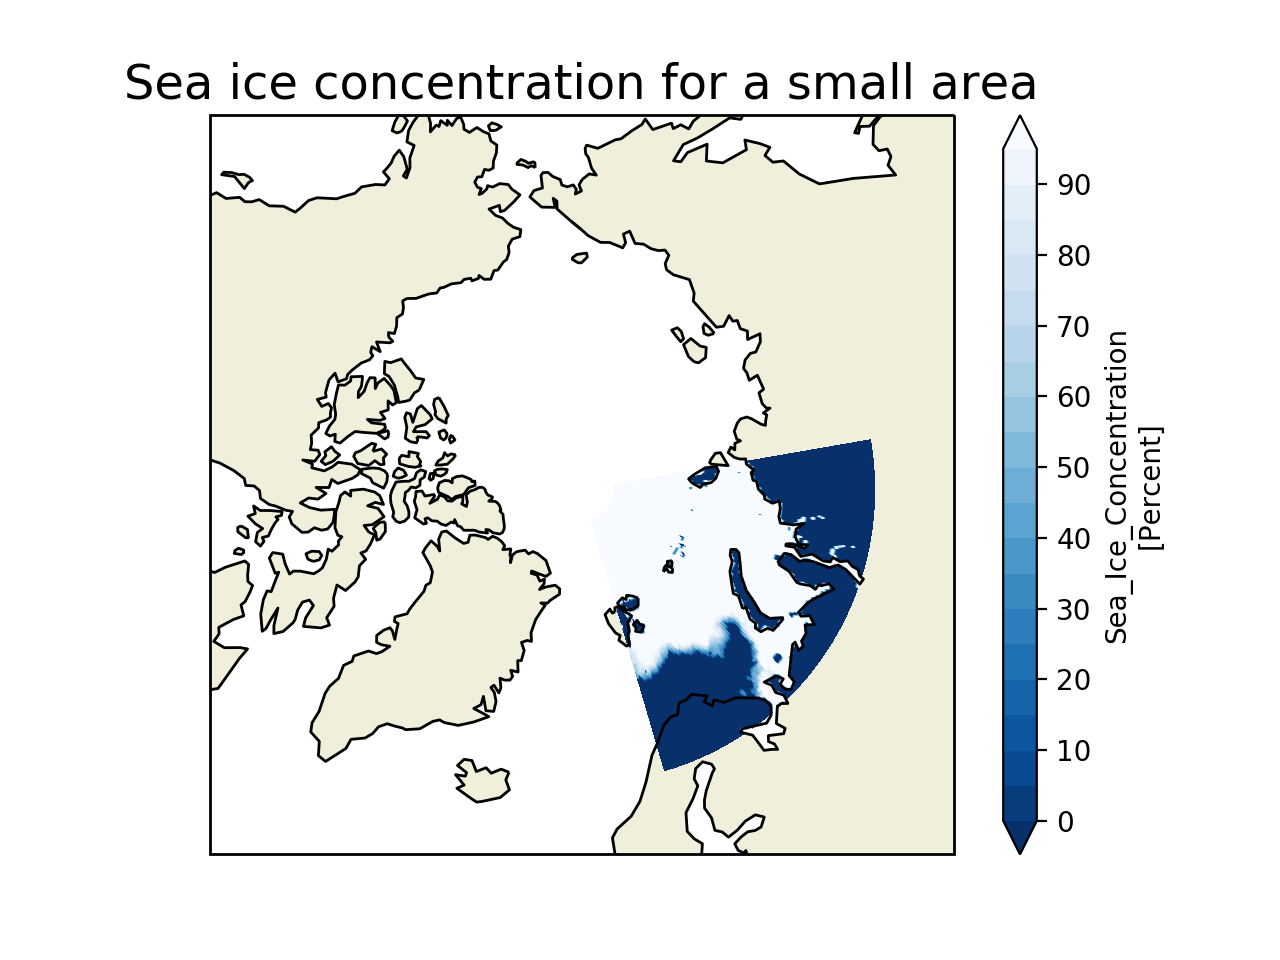

In [89]:
draw_area(da)
draw_area(da1)

In [117]:
# Sum ice concentration in area selected
dsum = da1.sum(dim=['latitude','longitude'])

# Generate datetime objects for x-axis
df_all = pd.merge(df,dsum.to_dataframe().reset_index())
X = df_all[['Month','NAO','NINO','AO','CO2']].values
Y = dsum.values
yrs = df_all['Year'].values

# Remove missing data point
X = np.delete(X,np.where(yrs==1984)[0][3],0)
Y = np.delete(Y,np.where(yrs==1984)[0][3])
yrs = np.delete(yrs,np.where(yrs==1984)[0][3])
dates = np.array([datetime.date(yrs[i],int(X[i,0]),15) for i in range(len(
    yrs))])

Now look at all time series data.

### NAO
- Low pressure system over Iceland and high pressure system over the Azores control the direction and strength of westerly winds into Europe,
- the NAO index encodes the pressure difference between these two points,
- large +ve index brings cool summers and mild, wet winters in Central Europe, -ve index is associated with cold, dry winters in Northern Europe and storms in Southern Europe,

### AO
- Close relative of the NAO
- ringlike pressure anomalies centered on the poles
- believed to be causally related to global weather patterns

### NINO
- El Nino-Southern oscillation index,
- drives winds and sea surface temperatures across the tropical Pacific

### CO2 concentration
- Atmospheric concentration of CO2 at the Mauna Loa observatory, Hawaii    

<IPython.core.display.Javascript object>


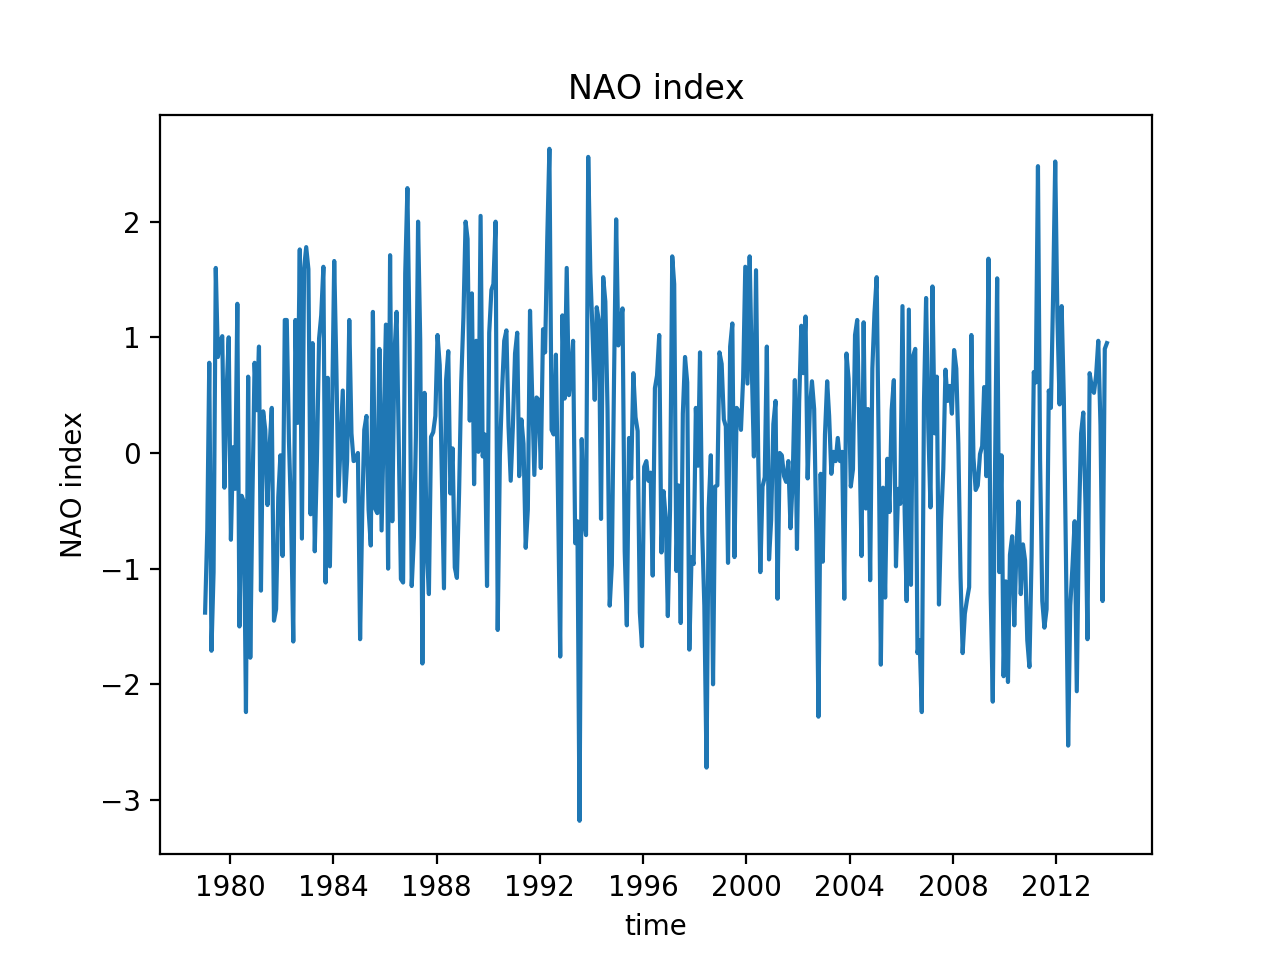

<IPython.core.display.Javascript object>


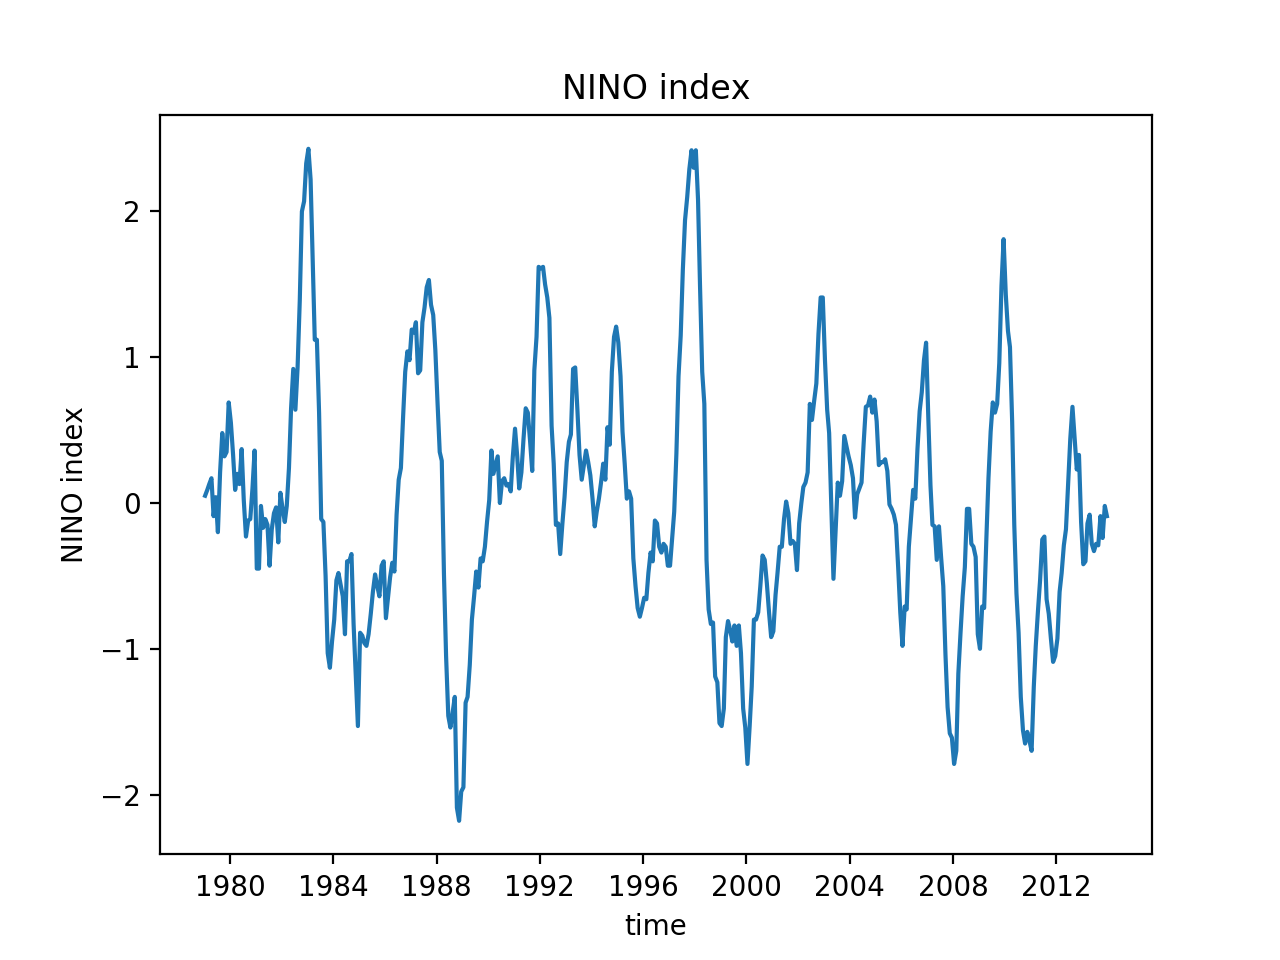

<IPython.core.display.Javascript object>


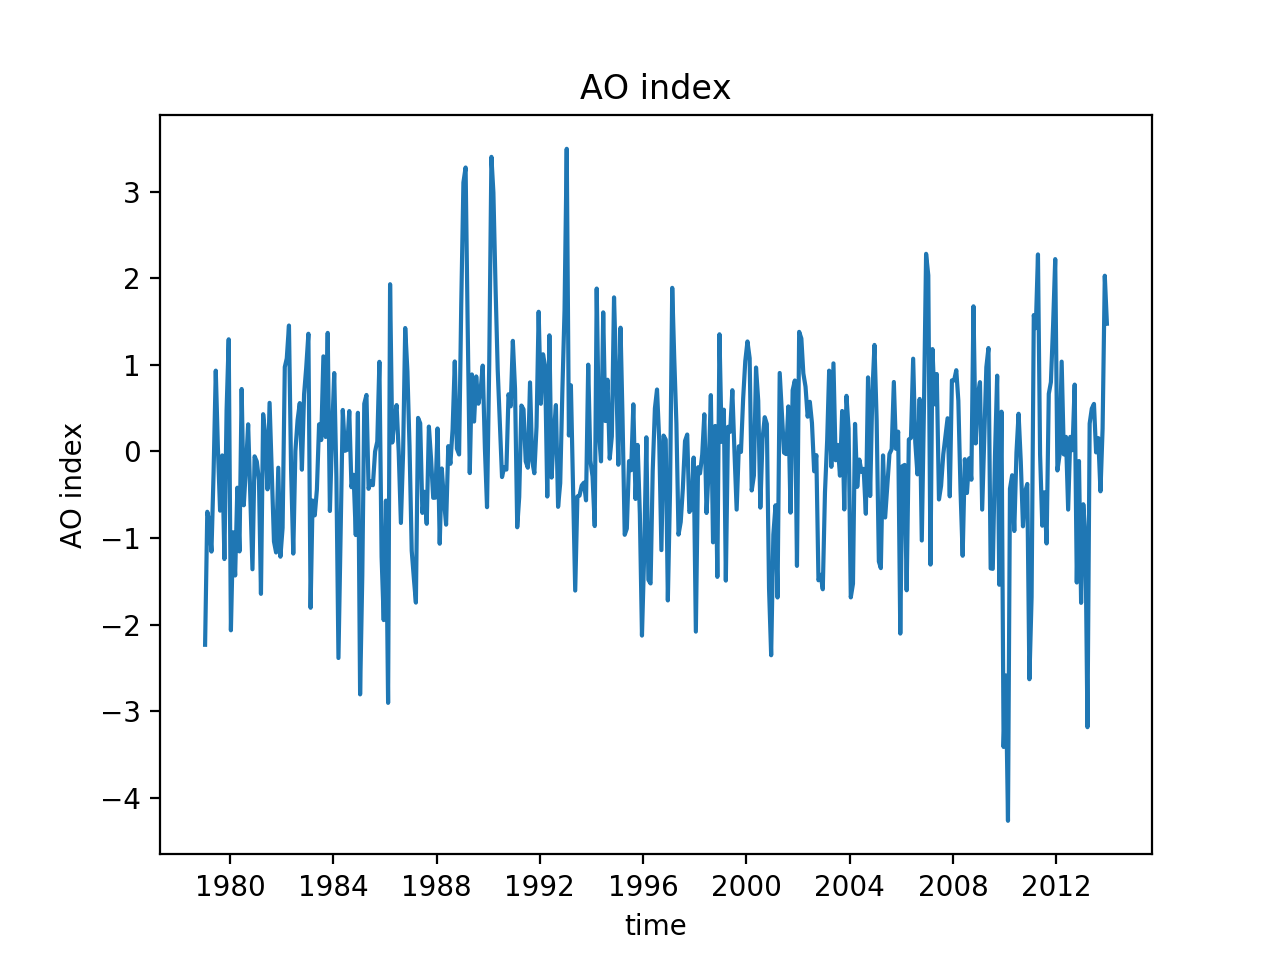

<IPython.core.display.Javascript object>


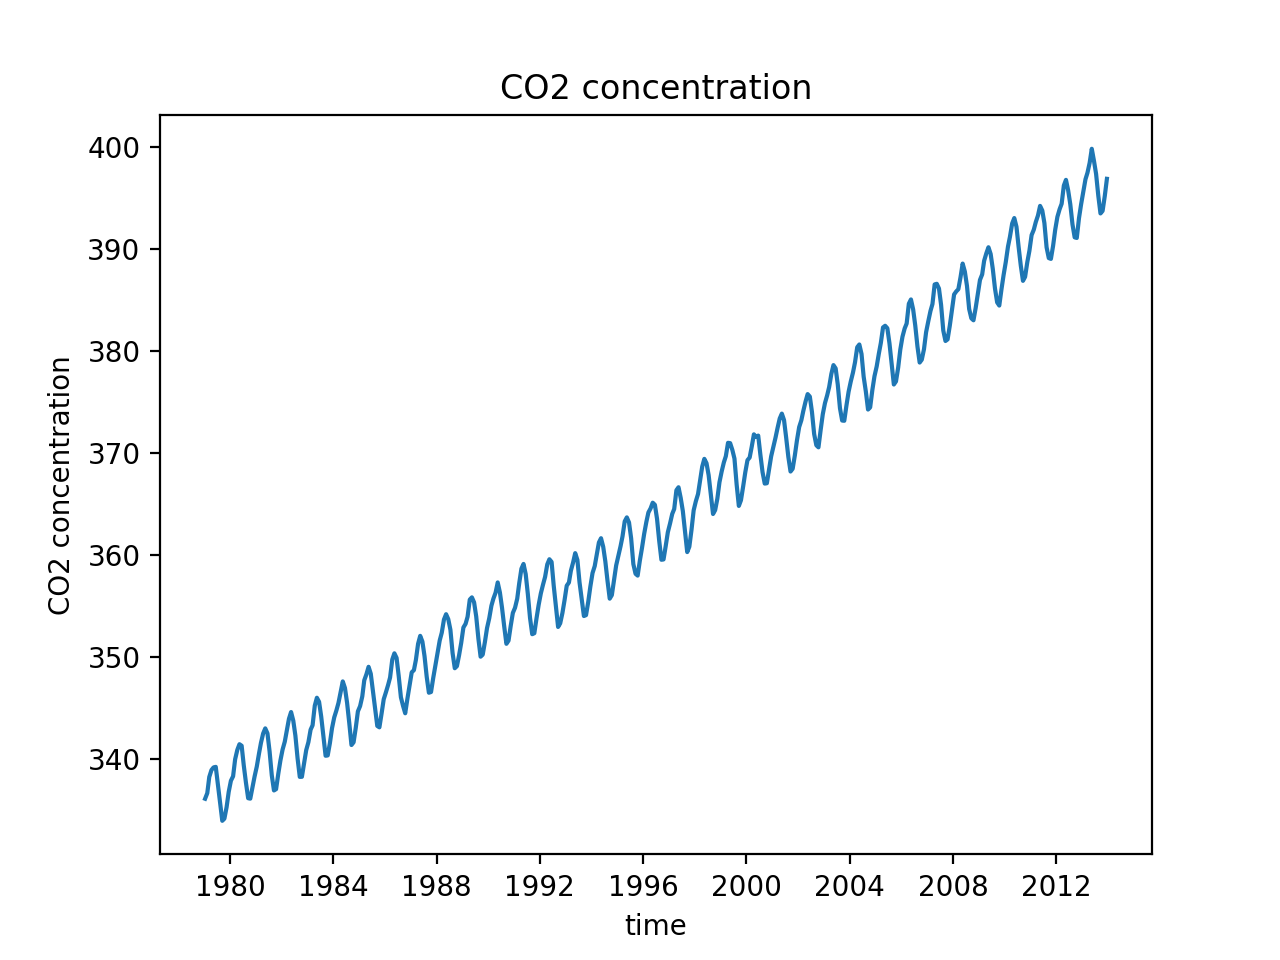

<IPython.core.display.Javascript object>


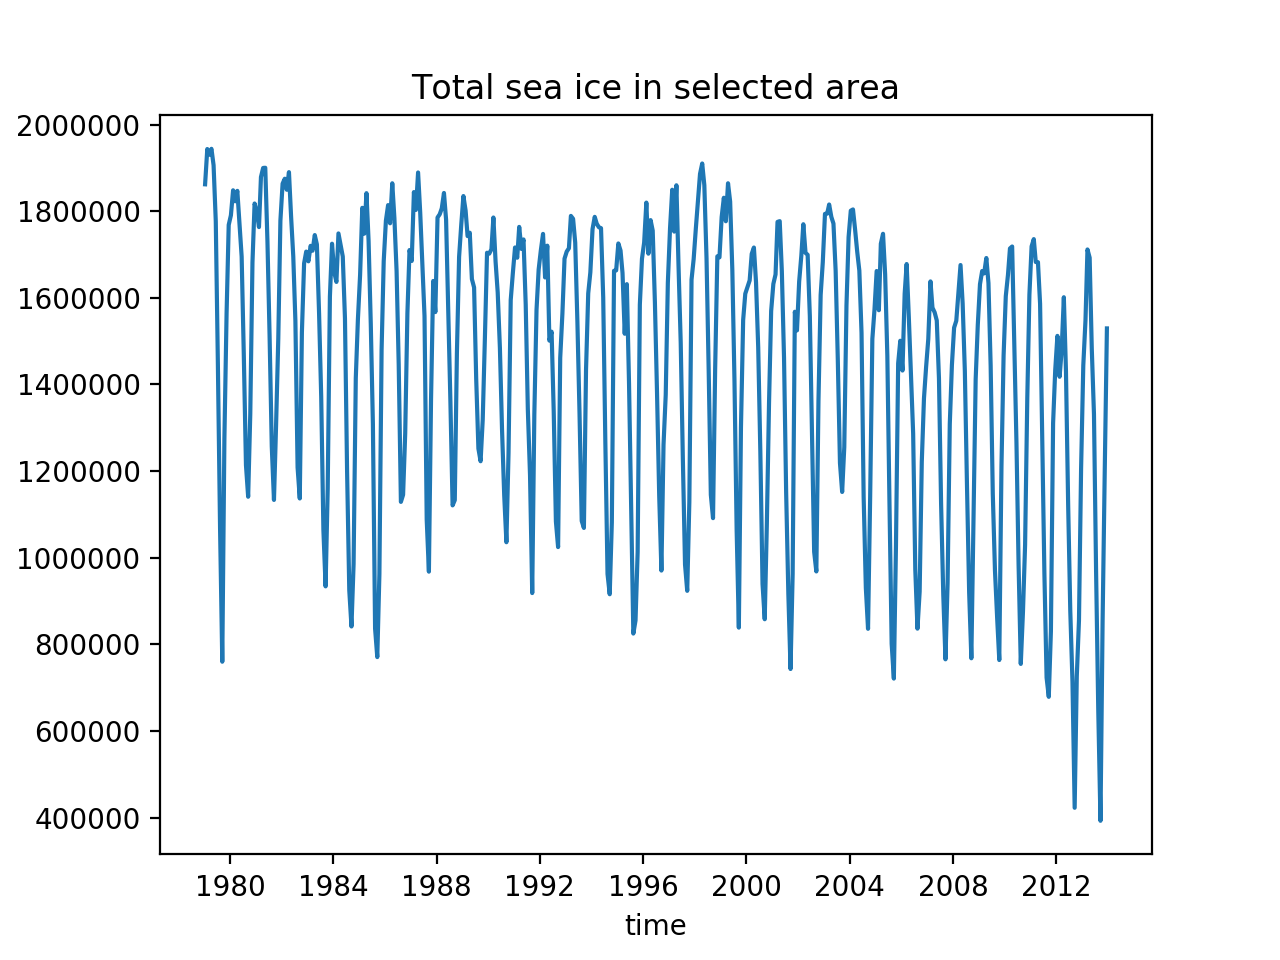

In [118]:
plot(dates, X[:,1], ['time','NAO index'])
plot(dates, X[:,2], ['time', 'NINO index'])
plot(dates, X[:,3], ['time', 'AO index'])
plot(dates, X[:,4], ['time', 'CO2 concentration'])
plot(dates, Y, ['time', 'Total sea ice in selected area'])

## Predicition of sea ice extent in an area (over Barents-Kara seas)

### 1. Naive time series

In this first attempt, we shall fit a GP to the sea ice extent as a function of time only. We'll be using a kernel of the form discussed in Rasmussen (2006), Ch 5.4.3 "Mauna Loa CO2".

The training/testing set split is at 2010.

<IPython.core.display.Javascript object>


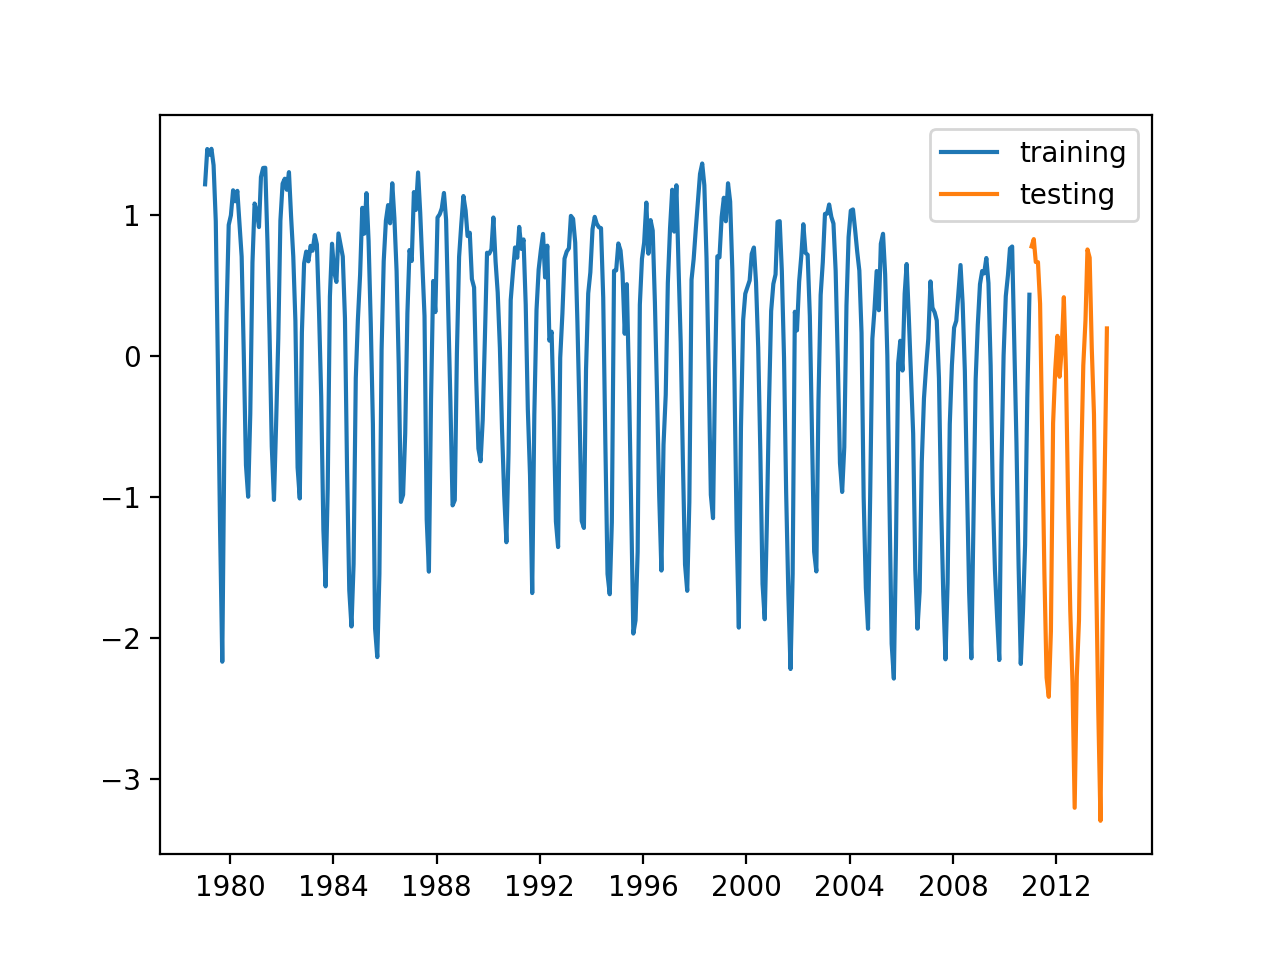

In [119]:
# Split data into training and testing datasets
train_ind, test_ind = np.where(yrs <= 2010)[0], np.where(yrs > 2010)[0]
Y_scaled = preprocessing.scale(Y)
X_train_dates, X_test_dates, Y_train, Y_test = dates[train_ind], dates[test_ind],\
                                    Y_scaled[train_ind], Y_scaled[test_ind]

plt.figure()
plt.plot(X_train_dates, Y_train,label='training')
plt.plot(X_test_dates, Y_test,label='testing')
plt.legend()
plt.show()

In [120]:
# Design kernel

k1 = RBF(input_dim=1,lengthscales=32,variance=0.5**2)
k2 = RBF(input_dim=1,lengthscales=100,variance=1)*Periodic(input_dim=1,period=1,lengthscales=1.2)
k3 = RationalQuadratic(input_dim=1,alpha=100,lengthscales=10.,variance=0.5**2)
k4 = RBF(input_dim=1,lengthscales=0.2,variance=0.01**2) + White(input_dim=1,variance=1e-5)
kernel = k1+k2+k3+k4

In [121]:
kernel

,class,prior,transform,trainable,shape,fixed_shape,value
Sum/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,32.0
Sum/kernels/0/variance,Parameter,None,+ve,True,(),True,0.25
Sum/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,100.0
Sum/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,1.2
Sum/kernels/1/kernels/1/period,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,1.0
Sum/kernels/2/alpha,Parameter,None,+ve,True,(),True,100.0
Sum/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,10.0
Sum/kernels/2/variance,Parameter,None,+ve,True,(),True,0.25


In [147]:
X_train = np.array([(X_train_date - X_train_dates[0]).days/365. for X_train_date in X_train_dates])
X_test = np.array([(X_test_date - X_train_dates[0]).days/365. for X_test_date in X_test_dates])
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)

In [143]:
model = gpflow.models.GPR(X_train.astype('float64'),
                         Y_train.astype('float64'),
                         kernel)
gpflow.train.ScipyOptimizer().minimize(model,disp=True)

In [144]:
X_all_dates = dates.reshape(-1,1)
X_all = np.array([(X_all_date[0] - X_all_dates[0][0]).days/365. for X_all_date in X_all_dates])
X_all = X_all.reshape(-1,1)
Y_pred_mean, Y_pred_var = model.predict_y(X_all)

<IPython.core.display.Javascript object>


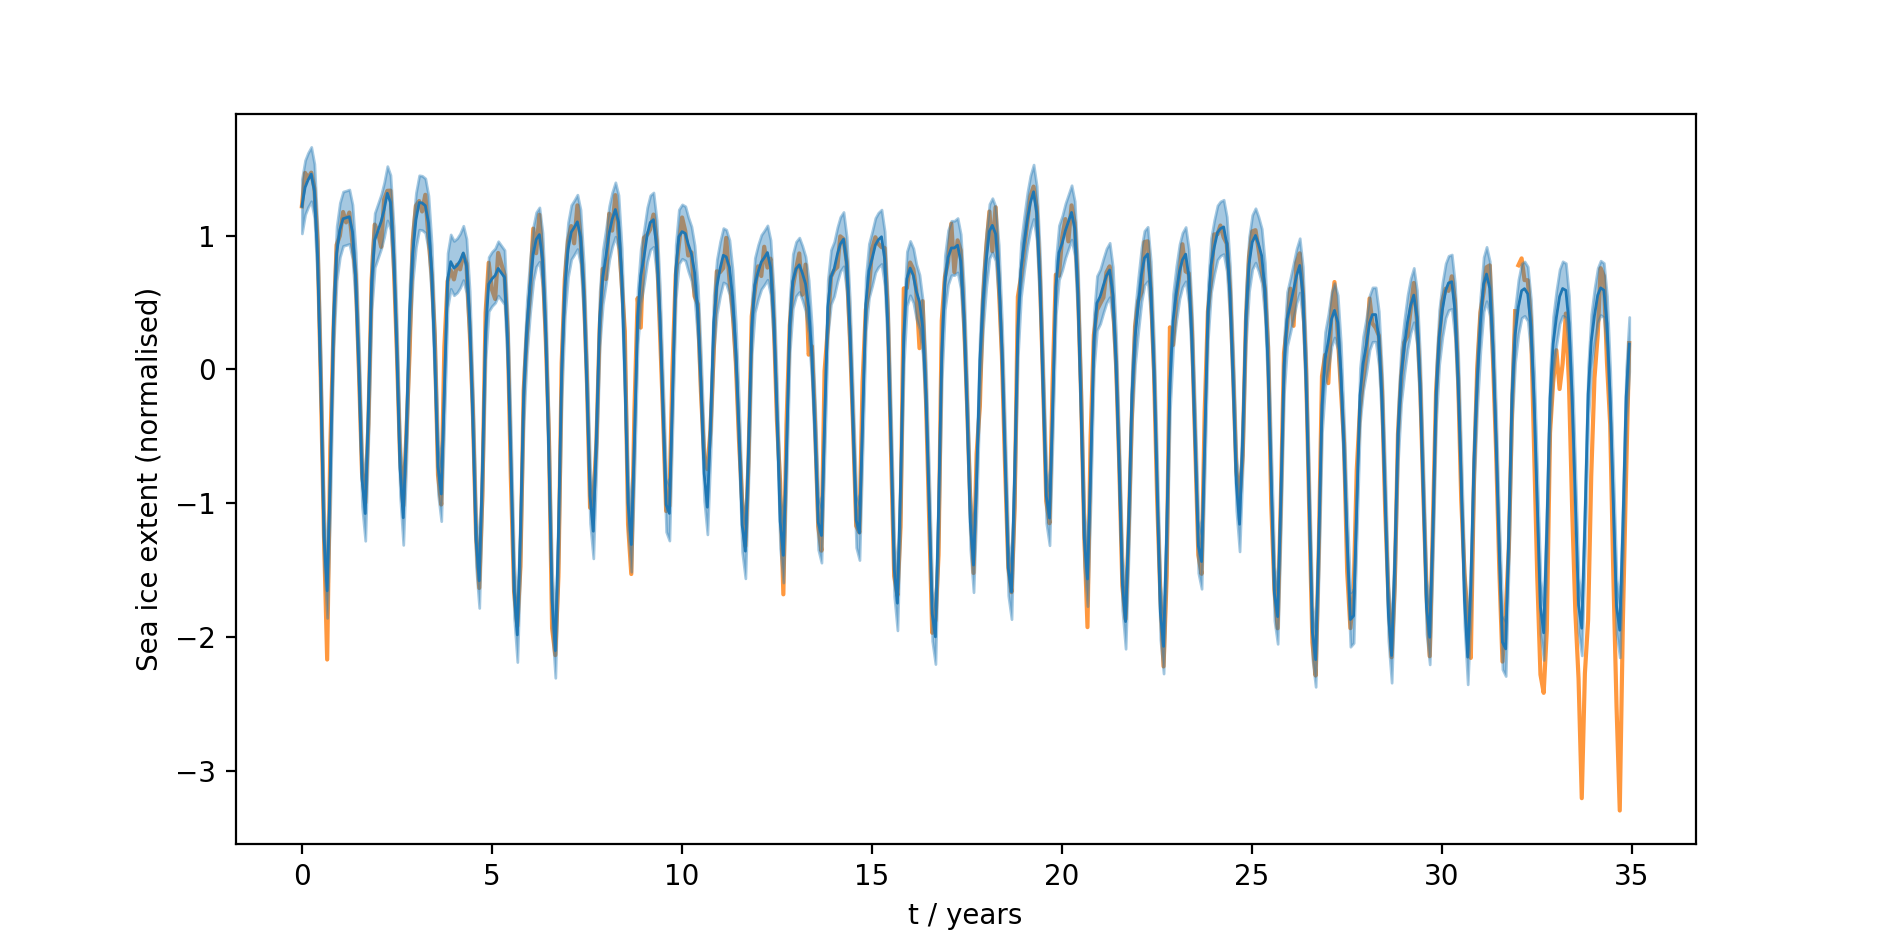

In [148]:
plt.figure()
plt.plot(X_all, Y_pred_mean, lw=1,color='C0',zorder=9)
plt.fill_between(X_all.flatten(), (Y_pred_mean - np.sqrt(np.diag(Y_pred_var))).flatten(),
                 (Y_pred_mean + np.sqrt(np.diag(Y_pred_var))).flatten(),
                 alpha=0.4,color='C0',zorder=9)
plt.plot(X_train, Y_train,color='C1',alpha=0.8)
plt.plot(X_test, Y_test,color='C1',alpha=0.8)
plt.xlabel('t / years')
plt.ylabel('Sea ice extent (normalised)')
plt.show()

In [350]:
kernel

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,32.46921367467851
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,0.2985234219551528
GPR/kern/kernels/1/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,102.21803745242359
GPR/kern/kernels/1/kernels/0/variance,Parameter,None,+ve,True,(),True,0.9642016983621349
GPR/kern/kernels/1/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.5652439070700019
GPR/kern/kernels/1/kernels/1/period,Parameter,None,+ve,True,(),True,1.000706977157304
GPR/kern/kernels/1/kernels/1/variance,Parameter,None,+ve,True,(),True,0.964201698263581
GPR/kern/kernels/2/alpha,Parameter,None,+ve,True,(),True,99.99830294908104
GPR/kern/kernels/2/lengthscales,Parameter,None,+ve,True,(),True,1.2354427728703272
GPR/kern/kernels/2/variance,Parameter,None,+ve,True,(),True,0.04076584481631028


### 2. Draw each component of this naive model

Draw each member of the GP:

<IPython.core.display.Javascript object>


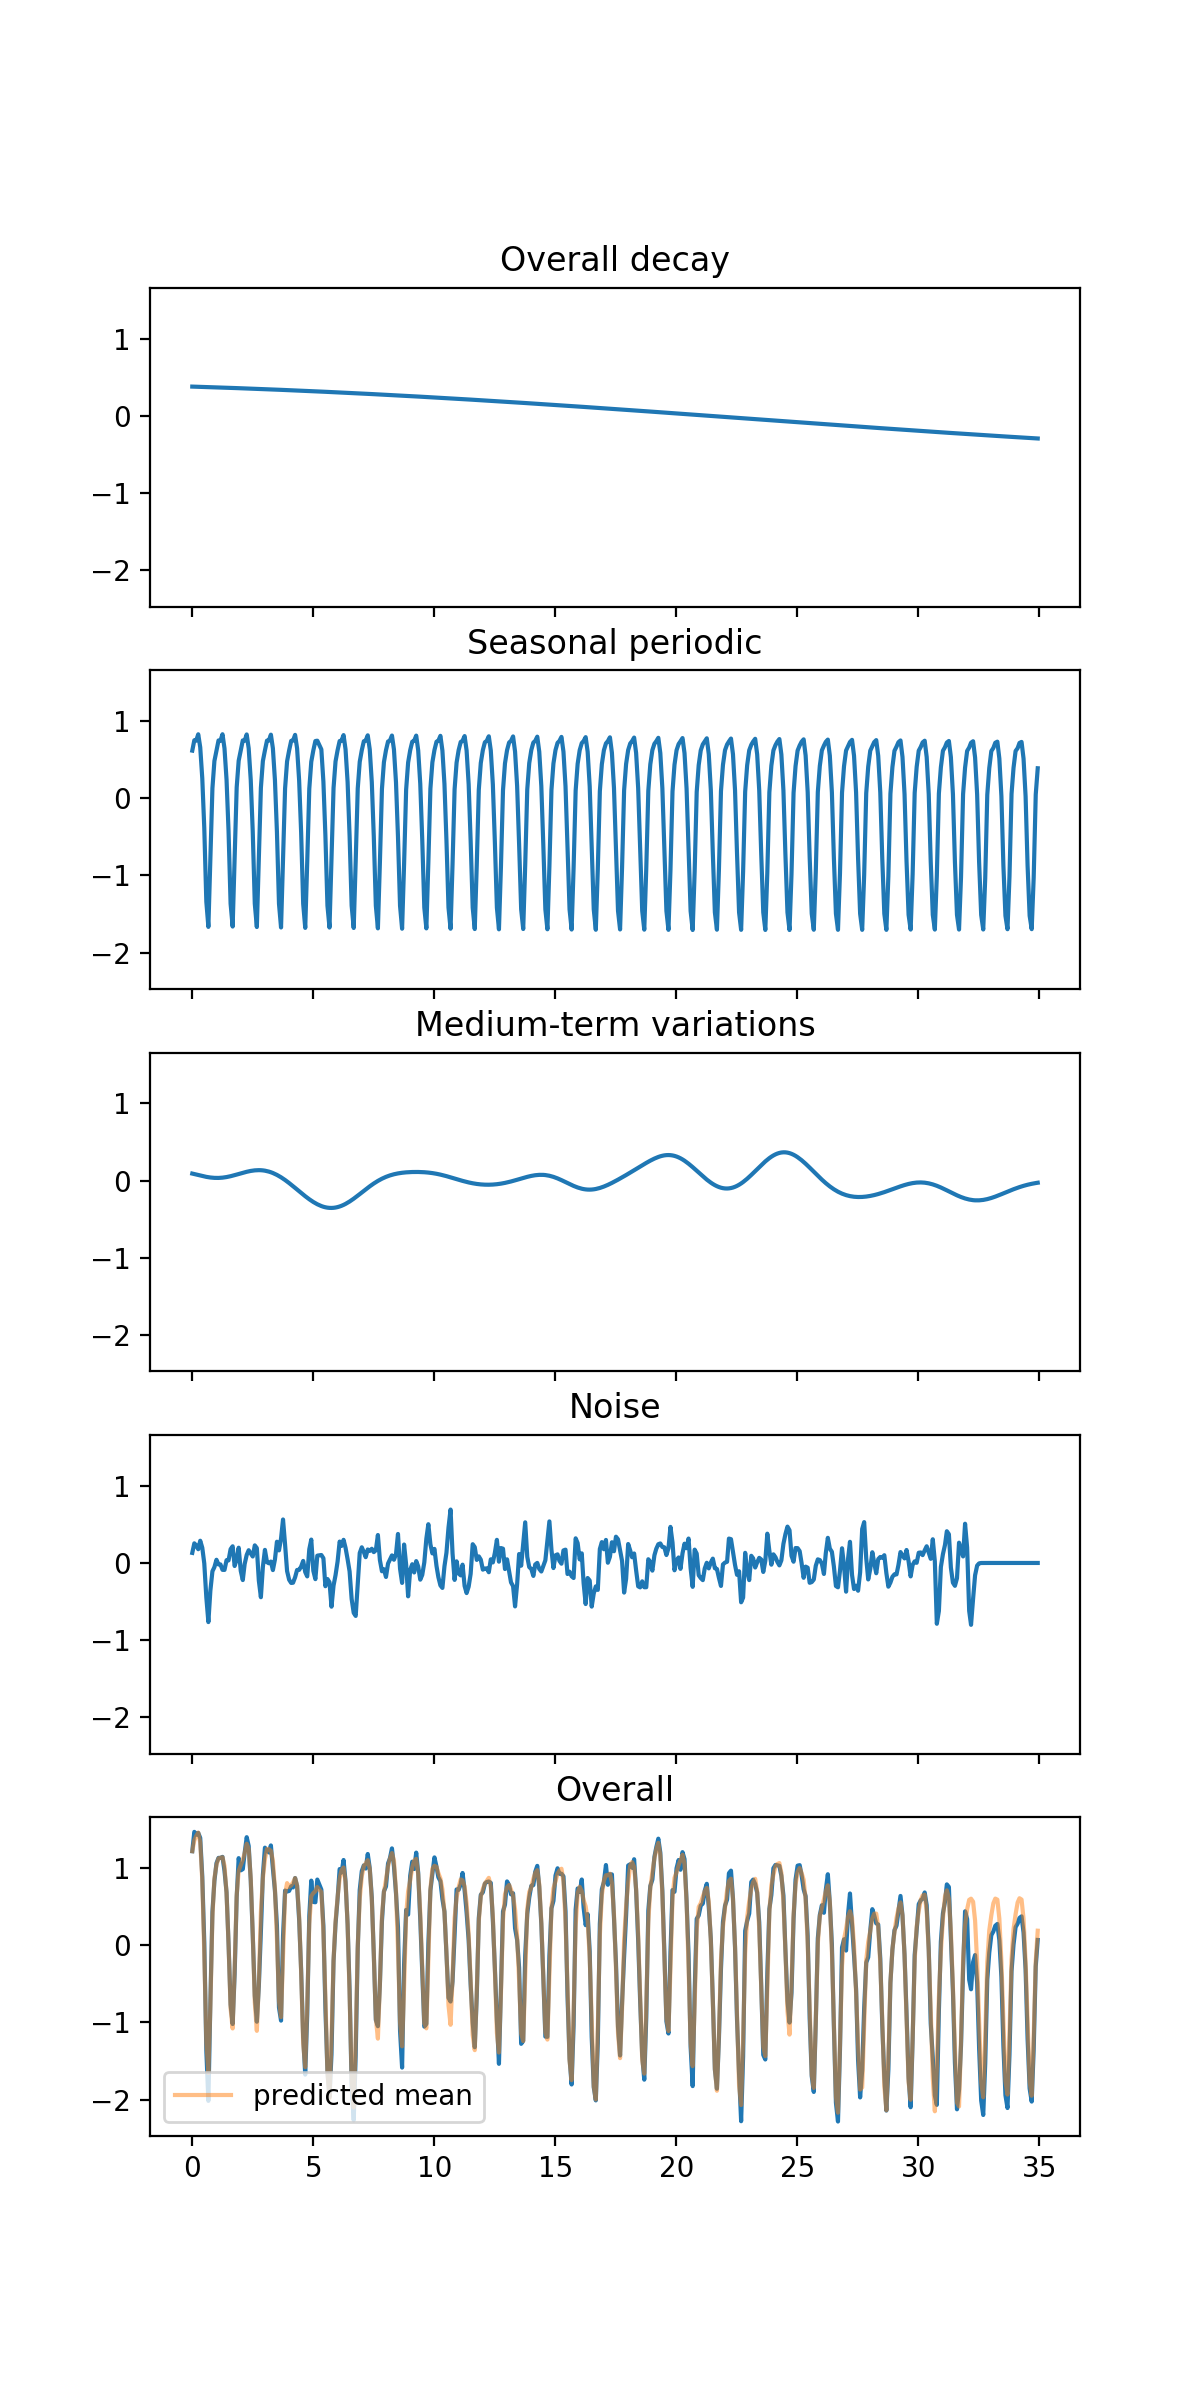

In [150]:
def plot_kernel_component(ksum, k, xs, x, y, ax, title):
    xs = xs.reshape(-1,1)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    ksumxx = ksum.compute_K_symm(x)
    ksx = k.compute_K(xs,x)
    mean = ksx@np.linalg.inv(ksumxx)@y
    ax.plot(xs,mean)
    ax.set_title(title)

f, axes = plt.subplots(5, 1, figsize=(6,12),sharex=True, sharey=True)
for i,k,title in zip(range(5),[k1,k2,k3,k4],['Overall decay', 'Seasonal periodic', 'Medium-term variations', 'Noise']):
    plot_kernel_component(kernel,k,X_all,X_all[train_ind],Y_scaled[train_ind],axes[i],title)
plot_kernel_component(kernel,k1+k2+k3+k4,X_all,X_all[train_ind],Y_scaled[train_ind],axes[4],'Overall')
axes[4].plot(X_all,Y_pred_mean,label='predicted mean',alpha=0.5)
axes[4].legend()
plt.show()

## Challenges and ideas for the hack

- GP cannot capture shape of minima
- Shape of throughs not the same as shape of peaks, kernel cannot capture this
- Uncertainties unknown
- Tricky projection - sea ice data gridded evenly in latitude and longitude
- Small dataset
- Try a neural network, use spatial map (image) instead of time series?
- Switch to time series data that are sampled weekly instead of monthly?
